# mixture density networks 


- About density estimation: http://scikit-learn.org/stable/modules/density.html


- http://tullo.ch/articles/speeding-up-isotonic-regression/

We want to model the conditional distribution as a mixture of Gaussians, where each Gaussian component parameters are dependent on the input, that is 


\begin{equation}
P(y^m \mid x^m) = \sum_{k=1}^K \pi_k(x^m) \mathcal{N} \left( y^m \mid \mu_k(x^m) , \sigma_k^2(x^m) \right)
\end{equation}

interactive widget for the notebook:
- https://jakevdp.github.io/blog/2013/12/05/static-interactive-widgets/


In [674]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


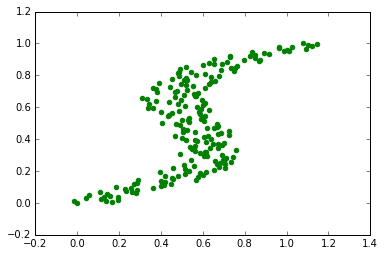

In [675]:
# generate some 1D regression data (reproducing Bishop book data, page 273). 
# Note that the P(y|x) is not a nice distribution.
# E.g. it has three modes for x ~= 0.5
N = 200
X = np.linspace(0,1,N)
Y = X + 0.3 * np.sin(2*3.1415926*X) + np.random.uniform(-0.1, 0.2, N)
X,Y = Y,X
plt.scatter(X,Y,color='g')

In [676]:
X = X.reshape(-1,1)
Y = Y.reshape( (1, len(Y)))

## About the model

Now we will present a mixture density network (MDN) with a single hidden layer. This model can be generalized using as many hidden layers as we want defined just like in a regular multilayer perceptron. The main difference between an standard MLP and a MDN is the output layer which will be specified in the following:

#### Weights

Let us assume we are training a MDN with $K$ Gaussian components and the objective is to build a density $P(t \mid x)$ where the target $t$ is a 1D variable (that is we are studying a 1D regression problem).

- First layer weights W1 defines a mapping from the input to the hidden layer.

- Second layer weights are composed by:

    - A weight matrix for the mixing coefficients $\pi_k$:  ```W_pi``` of shape ```(hidden_size, K)```
        
    - A weight matrix for the for the means of the Gaussian components $\mu_k$: ```W_mean``` of shape ```(hidden_size, K)```
    
    -  A weight matrix for the variances of the Gaussian components $\sigma_k^2$:  ```W_variance``` of shape ```(hidden_size, K)```

- Second layer biases are composed by:

    - A bias for the hidden layer: shape (hidden_size,1)
    
    - A bias for the mixing coefficients: shape (K,1)
    
    - A bias for the means of the Gaussian components: shape (K,1)
    
    - A bias for the variances of the Gaussian components: shape (K,1)


# Column implementation

In [677]:
import mixture_density_network_kar
from mixture_density_network_kar import MDNRegressor as MDNRegressorK

In [678]:
X.shape, Y.shape

((200, 1), (1, 200))

In [679]:
mdnk =  MDNRegressorK(hidden_layer_size=30,
                      n_components=3,
                      n_epochs=20000)

hidden size: 30
input size: 1
K (num components): 3


In [680]:
#data is sent as columns
mdnk.fit(X.T,Y)

hidden size: 30
input size: 1
K (num components): 3
X shape: (1, 200)
y  shape: (1, 200)
epoch:  0 loss:  1.07681923105
epoch:  1000 loss:  -0.512187466957
epoch:  2000 loss:  -0.660636857686
epoch:  3000 loss:  -0.716683668581
epoch:  4000 loss:  -0.738344592061
epoch:  5000 loss:  -0.74947490638
epoch:  6000 loss:  -0.75627688117
epoch:  7000 loss:  -0.761068956055
epoch:  8000 loss:  -0.764750218361
epoch:  9000 loss:  -0.767713302671
epoch:  10000 loss:  -0.770160496673
epoch:  11000 loss:  -0.772210572269
epoch:  12000 loss:  -0.77393926328
epoch:  13000 loss:  -0.775398143967
epoch:  14000 loss:  -0.776625273146
epoch:  15000 loss:  -0.777651669246
epoch:  16000 loss:  -0.778505022477
epoch:  17000 loss:  -0.77921141083
epoch:  18000 loss:  -0.779795694526
epoch:  19000 loss:  -0.780281215332


### Make a prediction

In [831]:
#x = np.array(X[20:21])
pos = 70
x = np.array(X[pos:pos+1])

In [832]:
x

array([[ 0.53829591]])

In [833]:
means, sigmas, mix_w= mdnk.predict_distribution(x)

In [834]:
print("means",means)
print("variances", sigmas)
print("mixing coefs",mix_w)

means [[ 0.19047296  0.76626715  0.51612722]]
variances [[ 0.03770213  0.0737099   0.12953479]]
mixing coefs [[ 0.1435799   0.11683672  0.73958338]]


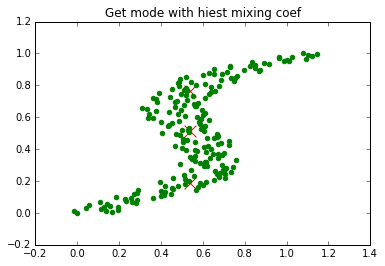

In [835]:
# Get prediction of the model with highest mix_w
N = 200
plt.scatter([x,x,x], means, color="red", marker="x",s=140)
plt.scatter(X,Y,color='g')
plt.title("Get mode with hiest mixing coef")

#### Choose the one with biggesnt mix_w

In [836]:
chosen_mode = np.argmax(mix_w)

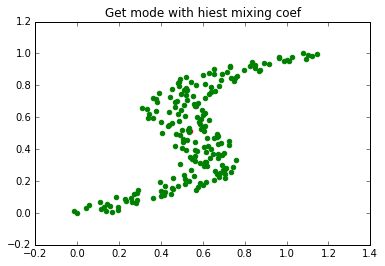

In [837]:
# Get prediction of the model with highest mix_w
N = 200
plt.scatter(x, means[0][chosen_mode], color="red")
plt.scatter(X,Y,color='g')
plt.title("Get mode with hiest mixing coef")

### Grid of predictions

In [838]:
means, variances, mixing_weights = mdnk.predict_distribution(X.T)

In [839]:
means.shape, variances.shape, mixing_weights.shape

((200, 3), (200, 3), (200, 3))

In [840]:
len(means)

200

In [845]:
preds = []
for k in range(len(means)):
    chosen_mode = np.argmax(mixing_weights[k])
    chosen_mean = means[k][chosen_mode]
    preds.append(chosen_mean)

In [842]:
mixing_weights[0]

array([  9.79151674e-01,   1.63474763e-05,   2.08319783e-02])

In [843]:
means[0]

array([ 0.00844962,  0.46290655,  1.01101264])

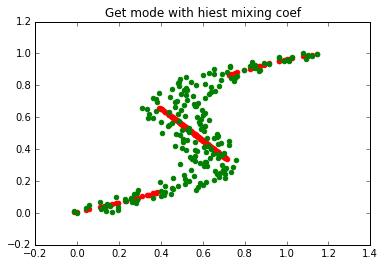

In [844]:
# Get prediction of the model with highest mix_w
plt.scatter(X, preds, color="red")
plt.scatter(X,Y,color='g')
plt.title("Get mode with hiest mixing coef")

### Plot posterior

In [829]:
# utility function for creating contour plot of the predictions
x_grid_max  = 1

def drawContour(model):
    n = 50
    xx = np.linspace(0,x_grid_max,n)
    yy = np.linspace(0,x_grid_max,n)
    xm, ym = np.meshgrid(xx, yy)
    
    x_grid = xm.reshape(1, xm.size)
    y_grid =  ym.reshape(1, ym.size)
    
    print("x_grid :", x_grid.shape)
    print("y_grid: ", y_grid.shape)

    stats = model._compute_loss(x_grid, y_grid)
    logps =  stats['elementwise_logprop']

    plt.figure(figsize=(10,10))

    plt.scatter(X,Y,color='g')
    
    plt.contour(xm,
                ym,
                np.reshape(logps, (n, n)), 
                levels=np.linspace(logps.min(), logps.max(), 50))
    
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.title('3-component Gaussian Mixture Model for P(y|x)')

x_grid : (1, 2500)
y_grid:  (1, 2500)


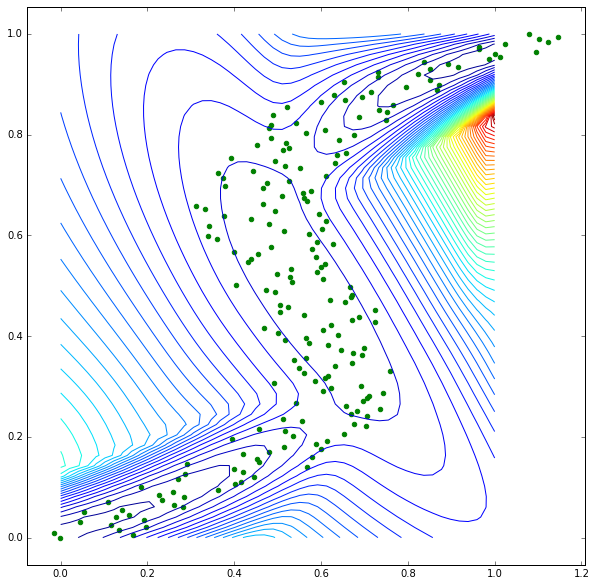

In [830]:
drawContour(model=mdnk)

# row implementation (problems)

In [94]:
import mixture_density_network
from mixture_density_network import MDNRegressor

In [95]:
X = X.reshape(-1,1)
X.shape, Y.shape

((200, 1), (200,))

In [54]:
mdn =  MDNRegressor(hidden_layer_size=30,
                    n_components=3,
                    n_epochs=20000)

NameError: name 'MDNRegressor' is not defined

In [97]:
mdn.fit(X,Y)

epoch:  0 loss:  5.27413579975
epoch:  1000 loss:  5.2255977649
epoch:  2000 loss:  5.17548300745
epoch:  3000 loss:  5.12344629575
epoch:  4000 loss:  5.06915620186
epoch:  5000 loss:  5.01231685546
epoch:  6000 loss:  4.95270767167
epoch:  7000 loss:  4.89024939253
epoch:  8000 loss:  4.82510408954
epoch:  9000 loss:  4.75780876666
epoch:  10000 loss:  4.68941913711
epoch:  11000 loss:  4.62159741906
epoch:  12000 loss:  4.55653400257
epoch:  13000 loss:  4.49661232997
epoch:  14000 loss:  4.44388062371
epoch:  15000 loss:  4.39960454874
epoch:  16000 loss:  4.36416904183
epoch:  17000 loss:  4.33729502796
epoch:  18000 loss:  4.31830922037
epoch:  19000 loss:  4.30631479603
epoch:  20000 loss:  4.30031174116
epoch:  21000 loss:  4.29935305708
epoch:  22000 loss:  4.30276292201
epoch:  23000 loss:  4.31042203482
epoch:  24000 loss:  4.323160945
epoch:  25000 loss:  4.34332390232
epoch:  26000 loss:  4.37545231858
epoch:  27000 loss:  4.42681757494
epoch:  28000 loss:  4.5083153925
ep

In [98]:
X.shape, Y.shape

((200, 1), (200,))

In [99]:
mdn._compute_loss(X[0:5],Y[0:5])

{'elementwise_logprop': array([[ 1.40822078],
        [ 2.90829707],
        [ 2.33928891],
        [ 1.83577104],
        [ 1.42967067]]), 'loss': 1.9842496915276073}

In [100]:
# utility function for creating contour plot of the predictions
def drawContour(model):
    n = 50
    xx = np.linspace(0,1,n)
    yy = np.linspace(0,1,n)
    xm, ym = np.meshgrid(xx, yy)
    
    x_grid = xm.reshape(xm.size, 1)
    y_grid =  ym.reshape(ym.size, 1)
    
    print("x_grid :", x_grid.shape)
    print("y_grid: ", y_grid.shape)

    stats = model._compute_loss(x_grid, y_grid)
    logps =  stats['elementwise_logprop']

    plt.figure(figsize=(10,10))

    plt.scatter(X,Y,color='g')
    
    plt.contour(xm,
                ym,
                np.reshape(logps, (n, n)), 
                levels=np.linspace(logps.min(), logps.max(), 50))
    
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.title('3-component Gaussian Mixture Model for P(y|x)')

x_grid : (2500, 1)
y_grid:  (2500, 1)


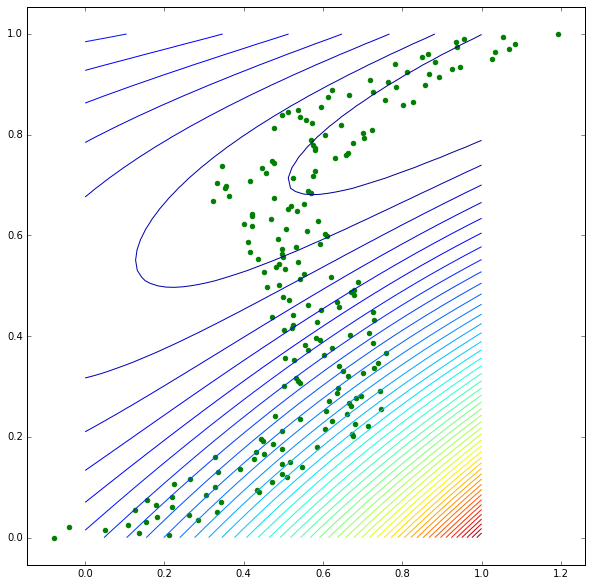

In [101]:
drawContour(model=mdn)

In [ ]:
X.shape

In [103]:
X.shape, Y.shape

((200,), (200,))

In [104]:
X = X.reshape(-1,1)

In [105]:
X.shape, Y.shape

((200, 1), (200,))

In [ ]:
X[0:3], Y[0:3]

In [ ]:
mdn._initialize_in_fit(n_features=1, n_hidden=4, n_outputs=1, n_components=5)

In [ ]:
Xbatch = X[0:3]
# activation at the hidden layer for each of the element s in the minibatch
act_h1 = np.dot(Xbatch, mdn.coefs_["W_1"]) + mdn.intercepts_["b_1"]

In [ ]:
np.dot(act_h1,mdn.coefs_['W_mean'])

In [ ]:
mdn.intercepts_['b_mean'].shape

In [ ]:
act_means = np.dot(act_h1,mdn.coefs_['W_mean']) + mdn.intercepts_['b_mean']

In [ ]:
#mdn.fit(X,Y)

In [ ]:
n_hidden = 10
a = {"b_1":  np.zeros(n_hidden, 0)}

In [ ]:
a = {"b_1":  np.zeros(100, 0)}

In [ ]:
np.zeros(100, 0)

In [ ]:
np.zeros(100,)